# Explore here

In [18]:
# Your code here
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split

url = "https://raw.githubusercontent.com/4GeeksAcademy/NLP-project-tutorial/main/url_spam.csv"
df_raw = pd.read_csv(url)

df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2999 entries, 0 to 2998
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   url      2999 non-null   object
 1   is_spam  2999 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 26.5+ KB


In [5]:
df_raw.sample(10,random_state=2025)

,url,is_spam
1897,https://briefingday.com/fan,True
98,https://seattle.eater.com/2020/6/18/21293916/s...,False
141,https://www.buzzfeednews.com/article/tanyachen...,False
2128,https://www.nytimes.com/2020/06/29/movies/sund...,False
2953,http://gettheelevator.com/editorial,True
2537,https://www.theverge.com/2020/6/29/21304947/re...,False
1801,https://www.earios.net/,False
1024,https://old.reddit.com/r/AskReddit/comments/he...,False
37,https://www.theobservereffect.org/marc.html,False
4,https://briefingday.com/fan,True


## Preprocessing


In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')

df_baking = df_raw.copy()

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_url(url):
    # Quitar protocolos (http, https)
    url = re.sub(r'https?://', '', url)
    # Tokenizar por signos
    tokens = re.split(r'\W+', url)
    # Lematizar y filtrar stopwords
    tokens = [lemmatizer.lemmatize(token.lower()) for token in tokens if token and token.lower() not in stop_words]
    return " ".join(tokens)

df_baking['clean_url'] = df_baking['url'].apply(preprocess_url)
df = df_baking.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2999 entries, 0 to 2998
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   url        2999 non-null   object
 1   is_spam    2999 non-null   bool  
 2   clean_url  2999 non-null   object
dtypes: bool(1), object(2)
memory usage: 49.9+ KB


[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/vscode/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## EDA

In [16]:
from sklearn.model_selection import train_test_split

X = df['clean_url']
y = df['is_spam']  #0 = no spam, 1 = spam

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

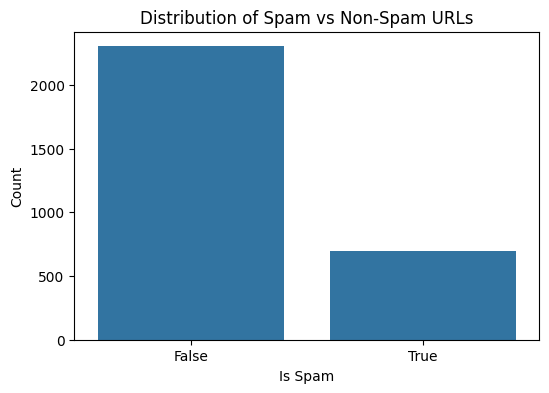

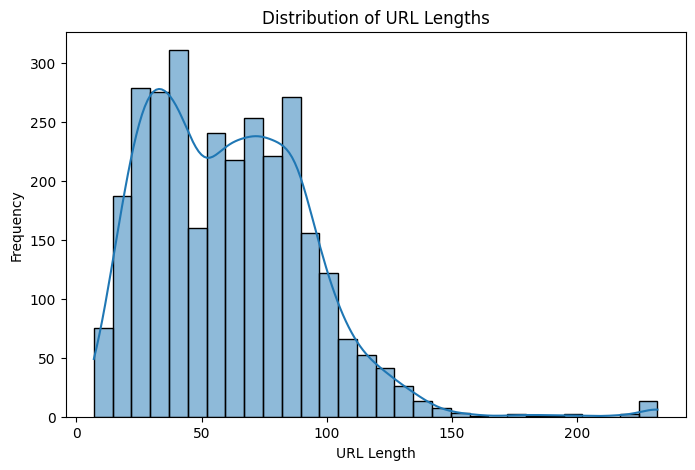

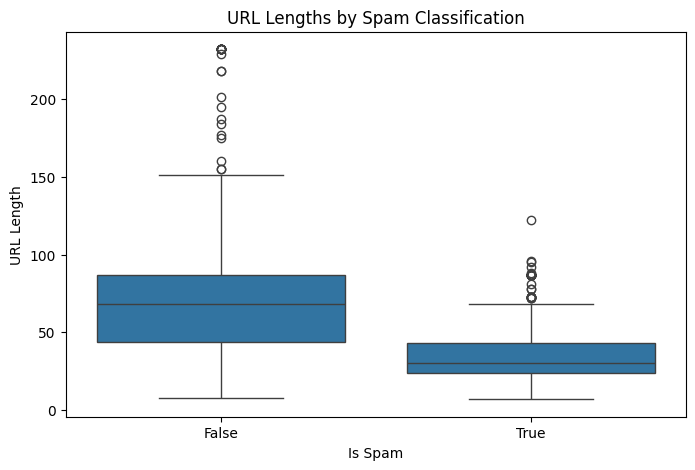

In [19]:
# Distribution of the target variable
plt.figure(figsize=(6, 4))
sns.countplot(x=y)
plt.title('Distribution of Spam vs Non-Spam URLs')
plt.xlabel('Is Spam')
plt.ylabel('Count')
plt.show()

# Length of clean_url strings
df['url_length'] = df['clean_url'].apply(len)

plt.figure(figsize=(8, 5))
sns.histplot(df['url_length'], bins=30, kde=True)
plt.title('Distribution of URL Lengths')
plt.xlabel('URL Length')
plt.ylabel('Frequency')
plt.show()

# Boxplot of URL lengths grouped by is_spam
plt.figure(figsize=(8, 5))
sns.boxplot(x=df['is_spam'], y=df['url_length'])
plt.title('URL Lengths by Spam Classification')
plt.xlabel('Is Spam')
plt.ylabel('URL Length')
plt.show()

El dataset esta desbalanceado

### Machine Learning (NLP)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

Confusion Matrix:


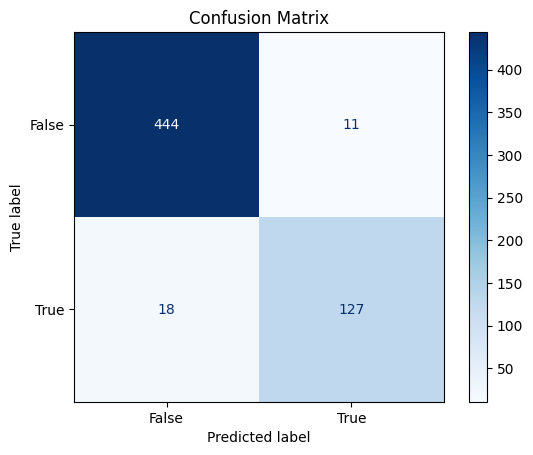

[[444  11]
 [ 18 127]]
              precision    recall  f1-score   support

       False       0.96      0.98      0.97       455
        True       0.92      0.88      0.90       145

    accuracy                           0.95       600
   macro avg       0.94      0.93      0.93       600
weighted avg       0.95      0.95      0.95       600



In [24]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

model = SVC()
model.fit(X_train_vec, y_train)
y_pred = model.predict(X_test_vec)

print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


In [25]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

grid = GridSearchCV(SVC(), param_grid, cv=5, n_jobs=-1, verbose=1)
grid.fit(X_train_vec, y_train)

print("Mejores parámetros:", grid.best_params_)
best_model = grid.best_estimator_

y_pred = best_model.predict(X_test_vec)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 18 candidates, totalling 90 fits
Mejores parámetros: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
[[436  19]
 [ 10 135]]
              precision    recall  f1-score   support

       False       0.98      0.96      0.97       455
        True       0.88      0.93      0.90       145

    accuracy                           0.95       600
   macro avg       0.93      0.94      0.94       600
weighted avg       0.95      0.95      0.95       600



### Guardar el modelo

In [26]:
import joblib

joblib.dump(best_model, '/workspaces/Proyecto-NLP/models/svm_spam_model.pkl')
joblib.dump(vectorizer, '/workspaces/Proyecto-NLP/models/tfidf_vectorizer.pkl')

['/workspaces/Proyecto-NLP/models/tfidf_vectorizer.pkl']